# Analysing nutritional information of menu items at different Fast-Food Companies


In [192]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import re

df = pd.read_csv("FastFoodNutritionMenuV2.csv")
df.head()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g),Weight WatchersPnts
0,McDonald’s,Hamburger,250,80,9,3.5,0.5,25,520,31,2,6,12,247.5
1,McDonald’s,Cheeseburger,300,110,12,6,0.5,40,750,33,2,6,15,297
2,McDonald’s,Double Cheeseburger,440,210,23,11,1.5,80,1150,34,2,7,25,433
3,McDonald’s,McDouble,390,170,19,8,1,65,920,33,2,7,22,383
4,McDonald’s,Quarter Pounder® with Cheese,510,230,26,12,1.5,90,1190,40,3,9,29,502


In [193]:
df.shape

(1148, 14)

In [194]:
# Just getting an idea of what companies are involved 
# and what proprtion of the data belongs to each company
(df.groupby("Company")["Item"].count()*100)/df.shape[0]

Company
Burger King    16.550523
KFC            18.989547
McDonald’s     28.658537
Pizza Hut       6.445993
Taco Bell      15.940767
Wendy’s        13.414634
Name: Item, dtype: float64

## Cleaning and Wrangling the data

In [195]:
# remove whitespaces
df.columns  = df.columns.str.strip()

# convert some columns columns to numeric
for column in df.columns:
    if column != "Company" and column != "Item":
        df[column] = pd.to_numeric(df[column], errors="coerce")

In [196]:
# find out the proportion of null values for each column
def show_null_proportion():
    row = []
    for column in df.columns:
        # find proportions for each column
        row.append(df[df.isnull().any(axis=1)][column].isnull().sum()/df.shape[0])

    null_prop_df = pd.DataFrame(columns=df.columns)
    null_prop_df.loc[0] = row
    return null_prop_df

In [197]:
show_null_proportion()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g),Weight WatchersPnts
0,0.0,0.0,0.013066,0.45122,0.060105,0.060976,0.060105,0.025261,0.013937,0.060976,0.073171,0.026132,0.060105,0.236934


The Calories from Fat and Weight WatchersPnts columns seem to have a lot of missing values.
After calculating some Weight Watcher values using online calculators, the values in the table do not seem to be consistent. Therefore it's best to not consider finding Weight WatchersPnts for all entries

We will drop the Weight WatchersPnts column

In [198]:
df.drop(columns=["Weight WatchersPnts"], inplace=True)

In [199]:
df.head()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g)
0,McDonald’s,Hamburger,250.0,80.0,9.0,3.5,0.5,25.0,520.0,31.0,2.0,6.0,12.0
1,McDonald’s,Cheeseburger,300.0,110.0,12.0,6.0,0.5,40.0,750.0,33.0,2.0,6.0,15.0
2,McDonald’s,Double Cheeseburger,440.0,210.0,23.0,11.0,1.5,80.0,1150.0,34.0,2.0,7.0,25.0
3,McDonald’s,McDouble,390.0,170.0,19.0,8.0,1.0,65.0,920.0,33.0,2.0,7.0,22.0
4,McDonald’s,Quarter Pounder® with Cheese,510.0,230.0,26.0,12.0,1.5,90.0,1190.0,40.0,3.0,9.0,29.0


Calories from Fat can be calculated by:
Calories from Fat = 9(c/g) * Total Fat(g)

We can confirm that the data, where Total Fat and Calories from Fat do exist, roughly matches this formula

In [200]:
# we should expect when we divide Total Fat * 9 by Calories from Fat we get 1
test_df = df.dropna()
(test_df["Total Fat(g)"]*9 / test_df["Calories from Fat"]).describe()

count    437.000000
mean       1.003696
std        0.069578
min        0.900000
25%        0.981818
50%        1.001408
75%        1.020000
max        1.800000
dtype: float64

### Dealing with missing values
We will fill in the rest of the data in the Calories from Fat column using the formula, when the total fat does exist

In [201]:
def fill_cal_from_fat(r):
    # if "Calories from Fat" is empty and total fat exists
    if pd.isna(r["Calories from Fat"]) and not pd.isna(r["Total Fat(g)"]):
        
        return r["Total Fat(g)"] * 9
    # leave as it is
    return r["Calories from Fat"]

df["Calories from Fat"] = df.apply(fill_cal_from_fat, axis=1)

In [202]:
#check the new proportion
print(df[df.isnull().any(axis=1)]["Calories from Fat"].isnull().sum()/df.shape[0])

0.06010452961672474


Now deleting rows where all values are null (Items that have absolutely no information about them other than item name and company)

In [203]:
# filter enrtries that don't have all of these columns null
df = df[df[["Calories", "Calories from Fat", "Total Fat(g)", "Saturated Fat(g)", "Trans Fat(g)", "Cholesterol(mg)", "Sodium (mg)", "Carbs(g)", "Fiber(g)", "Sugars(g)", "Protein(g)" ]].notna().any(axis=1)]

In [204]:
show_null_proportion()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g)
0,0.0,0.0,0.0,0.047661,0.047661,0.048544,0.047661,0.012357,0.000883,0.048544,0.0609,0.013239,0.047661


In [205]:
companies = df.groupby("Company")["Item"].count().keys()

## Exploring the Data

### Investigating which Fast-Food companies are the least healthy and least unhealthy

In [206]:
# function that gets a columns filtered by company
def get_companies_dataseries(column:str):
    info =  []
    for company in companies:
        info.append(df[df["Company"] == company][column].dropna())
    return info

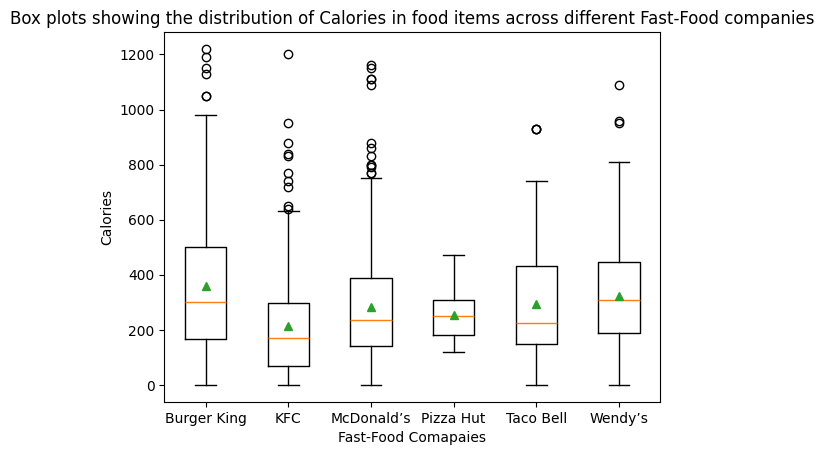

In [207]:
cal_info =  get_companies_dataseries("Calories")

plt.boxplot(cal_info, tick_labels=companies, showmeans=True)
plt.ylabel("Calories")
plt.xlabel("Fast-Food Comapaies")
plt.title("Box plots showing the distribution of Calories in food items across different Fast-Food companies")
plt.show()


In [208]:
for i in range(len(companies)):
    print(str(cal_info[i].median()) +" ", end="")

300.0 170.0 235.0 250.0 225.0 310.0 

Burger King and Wendy's have the highest median calories. However, Burger King has a high range and IQR of Calories for their menu items, which suggest they offer a wider veriety of high/low calorie food. Pizza hut has the smallest IQR which suggests it has food that a more calorie consistent. Companies other than Pizza Hut have outliers which implies they have a couple of menu items that are highly calorie dense. 

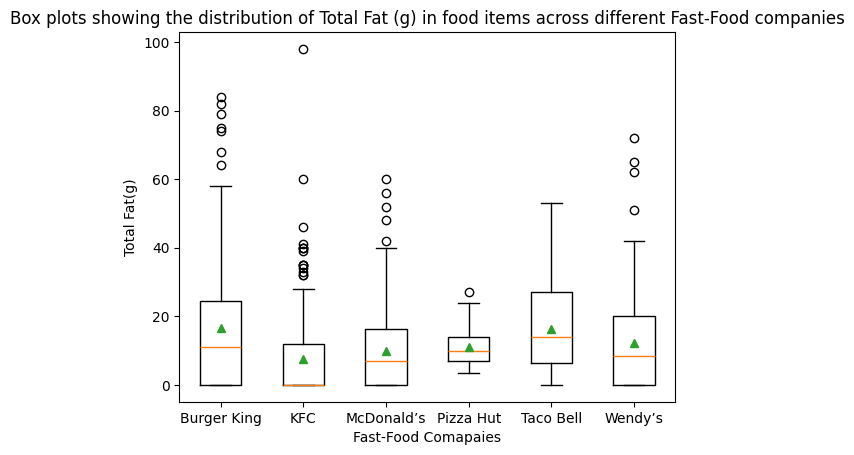

In [209]:
fat_info =  get_companies_dataseries("Total Fat(g)")

plt.boxplot(fat_info, tick_labels=companies, showmeans=True)
plt.ylabel("Total Fat(g)")
plt.xlabel("Fast-Food Comapaies")
plt.title("Box plots showing the distribution of Total Fat (g) in food items across different Fast-Food companies")
plt.show()


In [210]:
for i in range(len(companies)):
    print(str(fat_info[i].median()) +" ", end="")

11.0 0.0 7.0 10.0 14.0 8.5 

Taco Bell has the highest median total fat (14g) in their items with Burger King and Pizza Hut trailing closely. KFC has the lowest median (0g) and the lowest mean.
Burger King again has the highest highest range of total fat in their food items also indicating a wide variety of menu options. Pizza Hut has again displayed the lowest range of total fat in their menu. 

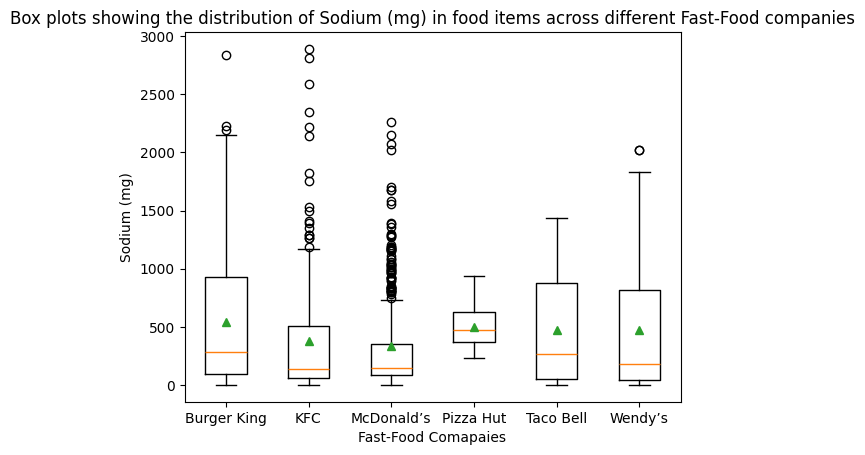

In [211]:
sod_info =  get_companies_dataseries("Sodium (mg)")

plt.boxplot(sod_info, tick_labels=companies, showmeans=True)
plt.ylabel("Sodium (mg)")
plt.xlabel("Fast-Food Comapaies")
plt.title("Box plots showing the distribution of Sodium (mg) in food items across different Fast-Food companies")
plt.show()


In [212]:
for i in range(len(companies)):
    print(str(sod_info[i].median()) +" ", end="")

280.0 140.0 145.0 475.0 270.0 180.0 

This time Pizza Hut has the highest median sodium on their menu (475mg). This is followed by Burger King (280mg) and Taco Bell (270mg). The rest (KFC, McDonald's, Wendy's) have much lower sodium in their menu, with KFC having the lowest (140mg)
Burger King and Wendy's have the highest ranges and Pizza Hut and McDonald's have the lowest.
This time most of the data seems to be right-skewed indicated by the mean departing from the median, with McDonald's having significantly more outliers than any other.

<hr>
From this information only, Burger King shows up quite a bit at the top. Taco Bell and Wendy's are comparable but Burger King consistently has the highest range. Pizza Hut was clearly the most nutrient consistent and KFC was the least unhealthy among the six options.

Pizza Hut's overall consistency may be explained due to its high proportion of pizzas, since most of a pizza remain the same with just the toppings varying

In [213]:
print(df[(df["Company"]== "Pizza Hut") & (df["Item"].str.contains("pizza", case=False))]["Item"].count()/df[df["Company"]== "Pizza Hut"]["Item"].count())

0.527027027027027


### Investigating which companies sell food with nutrients above the recommended limit

The World Health Organisation strongly recommends, for the prevention of unhealthy weight gain, that:
1. No more than 10% of total energy intake should come from saturated fats
2. No more than 1% of total energy intake should come from trans-fats


Assumption:
<ul>
<li>each food item is eaten without sharing
</ul>

Since there are 9c/g in Fats, we can work out much energy comes from saturated fats and trans fats

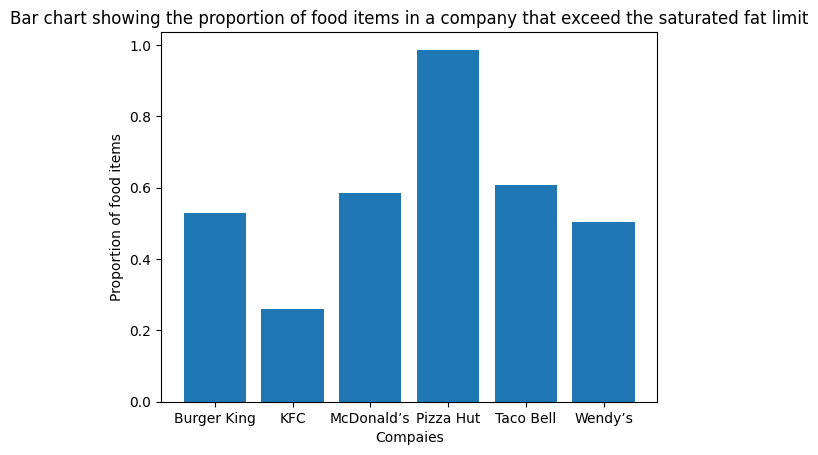

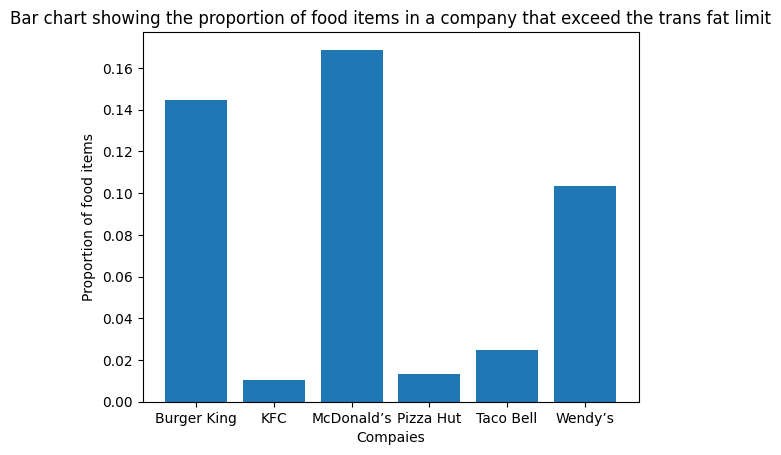

In [214]:
sf_lim = []
for company in companies:
    # we want to filter the items that exceed the saturated fat limit
    sf_filt = (9*df[df["Company"] == company]["Saturated Fat(g)"])/(df[df["Company"] == company]["Calories"])
    sf_lim.append(sf_filt[sf_filt>0.1].count()/sf_filt.count())

tf_lim = []
for company in companies:
    # we want to filter the items that exceed the trans fat limit
    tf_filt = (9*df[df["Company"] == company]["Trans Fat(g)"])/(df[df["Company"] == company]["Calories"])
    tf_lim.append(tf_filt[tf_filt>0.01].count()/tf_filt.count())

plt.title("Bar chart showing the proportion of food items in a company that exceed the saturated fat limit")
plt.xlabel("Compaies")
plt.ylabel("Proportion of food items")
plt.bar(companies, sf_lim)
plt.show()
plt.title("Bar chart showing the proportion of food items in a company that exceed the trans fat limit")
plt.xlabel("Compaies")
plt.ylabel("Proportion of food items")
plt.bar(companies, tf_lim)
plt.show()

If we assume that each food item is eaten without sharing:
Pizza Hut is the worst in terms of saturated fats and KFC having the least. However, it should be noted that KFC still has little over 20% of its food items exceeding the saturated fat limit which is still quite high.
Mcdonald's and Burger King are the worst in terms of trans fat with KFC and Pizza Hut having the least.

## Grouping data using Machine Learning

Menu items can include fried food, salad, drinks etc. These menu items are likely to vary in their nutrients but we can expect menu items of the same group to vary little compared to menu items in different groups. We can group menu items using K-means clustering. 

In [215]:
df.dropna(inplace=True)

In [216]:
df.describe()

,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g)
count,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000
mean,296.653772,105.314313,11.701644,4.121373,0.147002,37.620890,446.735977,39.540619,1.434236,23.651838,9.508704
std,226.415889,127.768291,14.188886,5.109594,0.499424,67.329056,506.930104,32.068610,2.404020,32.185701,11.185768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,17.000000,0.000000,2.000000,0.000000
50%,255.000000,70.000000,8.000000,3.000000,0.000000,15.000000,200.000000,34.500000,0.000000,8.000000,7.000000
75%,410.000000,160.000000,18.000000,6.000000,0.000000,45.000000,717.500000,53.000000,2.000000,38.000000,14.000000
max,1220.000000,882.000000,98.000000,33.000000,4.500000,575.000000,2890.000000,270.000000,31.000000,264.000000,71.000000


In [217]:
scaler = StandardScaler()

Transforming the data into a standard form. This is done by subtracting the mean from every point and dividing by the standard deviation. This ensures the data from all columns are treated with equal weight and are in the same range so that they can be compared.

In [218]:
# numeric columns and their transformed versions
num_columns = ["Calories","Calories from Fat","Total Fat(g)","Saturated Fat(g)","Trans Fat(g)","Cholesterol(mg)","Sodium (mg)","Carbs(g)","Fiber(g)","Sugars(g)","Protein(g)"]
num_columns_T = ["Calories_T","Calories from Fat_T","Total Fat(g)_T","Saturated Fat(g)_T","Trans Fat(g)_T","Cholesterol(mg)_T","Sodium (mg)_T","Carbs(g)_T","Fiber(g)_T","Sugars(g)_T","Protein(g)_T"]
df[num_columns_T] = scaler.fit_transform(df[num_columns])

In [219]:
df.head()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),...,Calories from Fat_T,Total Fat(g)_T,Saturated Fat(g)_T,Trans Fat(g)_T,Cholesterol(mg)_T,Sodium (mg)_T,Carbs(g)_T,Fiber(g)_T,Sugars(g)_T,Protein(g)_T
0,McDonald’s,Hamburger,250.0,80.0,9.0,3.5,0.5,25.0,520.0,31.0,...,-0.198223,-0.190498,-0.121668,0.707152,-0.187542,0.144595,-0.266452,0.235455,-0.548703,0.222828
1,McDonald’s,Cheeseburger,300.0,110.0,12.0,6.0,0.5,40.0,750.0,33.0,...,0.036691,0.021038,0.367844,0.707152,0.035353,0.598526,-0.204056,0.235455,-0.548703,0.491156
2,McDonald’s,Double Cheeseburger,440.0,210.0,23.0,11.0,1.5,80.0,1150.0,34.0,...,0.819737,0.796667,1.346869,2.710426,0.629737,1.387971,-0.172858,0.235455,-0.517618,1.385581
3,McDonald’s,McDouble,390.0,170.0,19.0,8.0,1.0,65.0,920.0,33.0,...,0.506518,0.514620,0.759454,1.708789,0.406843,0.934040,-0.204056,0.235455,-0.517618,1.117254
4,McDonald’s,Quarter Pounder® with Cheese,510.0,230.0,26.0,12.0,1.5,90.0,1190.0,40.0,...,0.976346,1.008203,1.542674,2.710426,0.778333,1.466916,0.014332,0.651626,-0.455448,1.743352


### Identifying optimal number of clusters
**inertia**: The sum of the squared distances to the centre of the cluster.
we will fit a bunch of k-means clustering models with the number of clusters varying. At some point the inertia should start to show "diminishing returns". The value at which this happens will be our K value

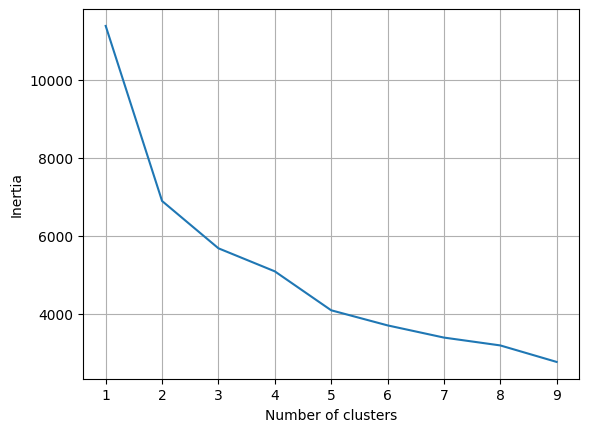

In [220]:
means = []
inertias = []

# try 1 to 10 clusters
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df[num_columns_T])
    means.append(k)
    inertias.append(kmeans.inertia_)

plt.plot(means, inertias)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


### Applying the K-means with K = 4

We will pick our k value to be 4

In [221]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[num_columns_T])


,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [222]:
# contains the labels for each row in order of the df ranging from 1-4
df["kmeans_4"] = kmeans.labels_

In [223]:
means_of_clusters = df.drop(columns=["Company", "Item"]).groupby("kmeans_4").mean()

In [224]:
means_of_clusters_T = means_of_clusters.drop(columns=num_columns)
means_of_clusters.drop(columns=num_columns_T, inplace=True)
# means_of_clusters contains the means of each nutrient for each cluster 
# means_of_clusters_T contains the means of each transformed nutrient for each cluster 

In [225]:
means_of_clusters

,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g)
kmeans_4,,,,,,,,,,,
0,819.642857,455.535714,50.625000,17.803571,1.339286,210.625000,1544.107143,55.839286,3.142857,12.000000,35.589286
1,434.036364,199.198182,22.089091,6.585455,0.132727,67.254545,955.600000,40.432727,3.494545,5.109091,18.530909
2,146.058520,36.126506,4.030981,1.602410,0.004303,10.043029,157.039587,24.831325,0.538726,19.032702,3.602410
3,464.098361,62.426230,6.950820,4.282787,0.311475,22.745902,175.614754,100.098361,0.270492,92.795082,5.327869


In [226]:
means_of_clusters_T
# this dataframe makes it easier to compare certain nutrients across different clusters

,Calories_T,Calories from Fat_T,Total Fat(g)_T,Saturated Fat(g)_T,Trans Fat(g)_T,Cholesterol(mg)_T,Sodium (mg)_T,Carbs(g)_T,Fiber(g)_T,Sugars(g)_T,Protein(g)_T
kmeans_4,,,,,,,,,,,
0,2.310978,2.742393,2.744556,2.679042,2.388471,2.570775,2.165786,0.508490,0.711079,-0.362194,2.332714
1,0.607065,0.735153,0.732438,0.482479,-0.028596,0.440345,1.004301,0.027832,0.857442,-0.576396,0.806969
2,-0.665449,-0.541772,-0.540872,-0.493226,-0.285865,-0.409796,-0.571749,-0.458904,-0.372685,-0.143585,-0.528274
3,0.739902,-0.335833,-0.334989,0.031606,0.329485,-0.221037,-0.535088,1.889294,-0.484317,2.149299,-0.373945


### Visualising the results

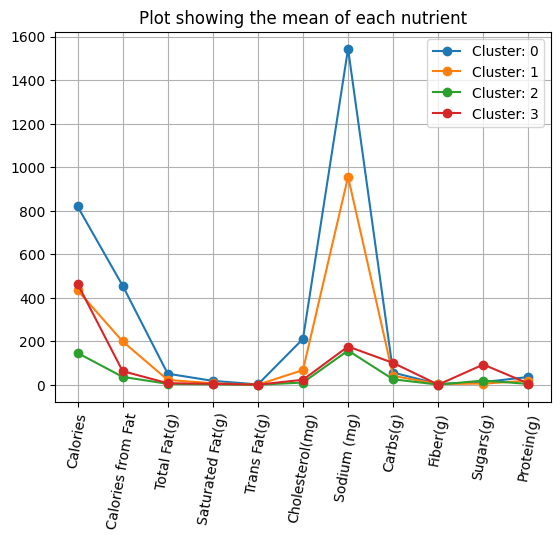

In [227]:
for i in range (0,4):
    plt.plot( means_of_clusters.columns, means_of_clusters.loc[i], label="Cluster: "+str(i), marker="o")
plt.legend()
plt.title("Plot showing the mean of each nutrient")
plt.grid()
plt.xticks(rotation=80)
plt.show()

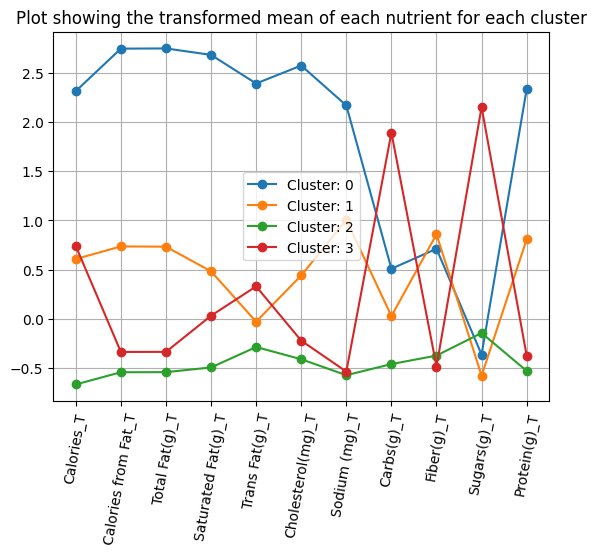

In [228]:
for i in range (0,4):
    plt.plot( means_of_clusters_T.columns, means_of_clusters_T.loc[i], label="Cluster: "+str(i), marker="o")
plt.legend()
plt.title("Plot showing the transformed mean of each nutrient for each cluster")
plt.grid()
plt.xticks(rotation=80)
plt.show()

In [229]:
def clean_items_in_cluster(k:int):
    stopwords = set(STOPWORDS) # common words like the, and ...

    # turn the items into a string of items seperated by a space
    text = ' '.join(df[df["kmeans_4"] == k]["Item"].astype(str).tolist())
    # remove anything that is not a letter
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stopwords)
    return text



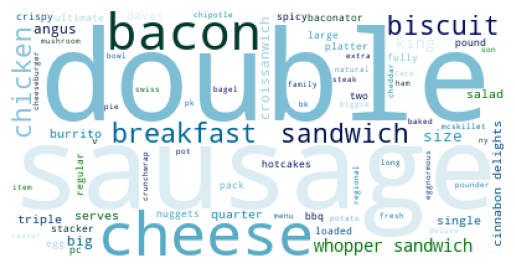

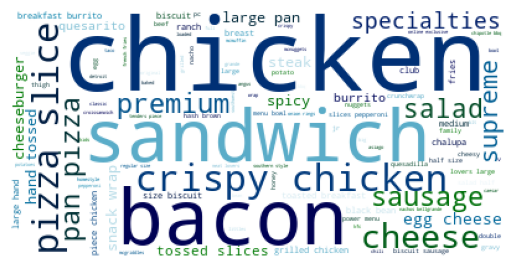

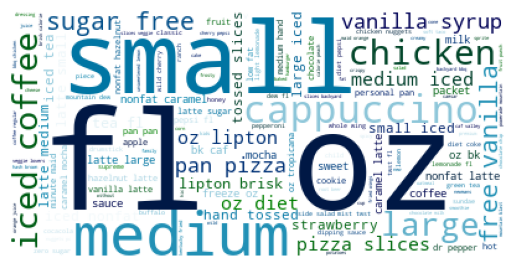

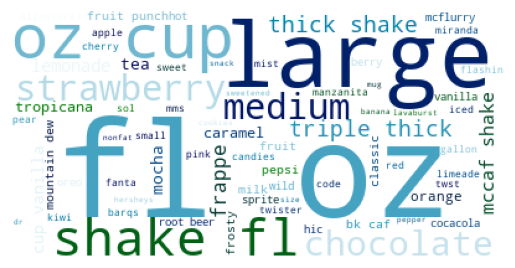

In [230]:
texts = []
for i in range(4):
    texts.append(clean_items_in_cluster(i))

    wordcloud = WordCloud(background_color='white', colormap="ocean").generate(texts[i])
    plt.imshow(wordcloud)
    plt.axis('off')  
    plt.show()

### Interpreting results

**Cluster 0:**
<br>&nbsp;&nbsp; Very high: Calories, Fats, Protein, Cholesterol, Sodium
<br>&nbsp;&nbsp; Very low: Sugars
<br>Seems to conatin mostly fatty breakfast foods, burgers and meat items

**Cluster 1:**
<br>&nbsp;&nbsp; Very high: None
<br>&nbsp;&nbsp; Medium: Everything else
<br>&nbsp;&nbsp; low: Sugars
<br> Seems to contain savoury items but not as extreme as cluster 0 

**Cluster 2:**
<br>&nbsp;&nbsp; Very high: None
<br>&nbsp;&nbsp; Very low: Everything
<br> Seems to be filled with mainly drinks indicated by the fl oz (fluid once) both cold and hot drinks, and small pizza slices



**Cluster 3:**
<br>&nbsp;&nbsp; Very high: Sugars
<br>&nbsp;&nbsp; high: Carbs
<br>&nbsp;&nbsp; Medium: Calories
<br>&nbsp;&nbsp; low: Fats, Sodium, Fibre, Protein
<br> Seems to contain mostly drinks and shakes. A lot more sweater items than cluster 2

It is clear that cluster 1 contains the most unhealthy food items

<BarContainer object of 6 artists>

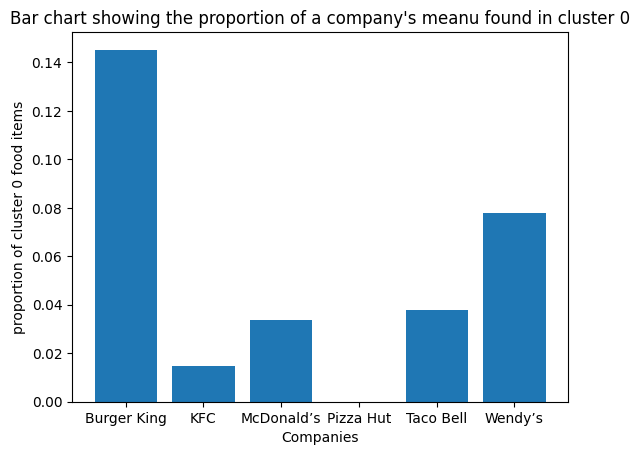

In [232]:
# show companies for cluster 1
clus_1_by_comp = []
for company in companies:
    #finding the proportion of cluster 1 food items in a company
    clus_1_by_comp.append(df[(df["Company"] == company) & (df["kmeans_4"] == 0)].shape[0]/df[df["Company"] == company].shape[0] )

plt.xlabel("Companies")
plt.ylabel("proportion of cluster 0 food items")
plt.title("Bar chart showing the proportion of a company's meanu found in cluster 0")
plt.bar(companies, clus_1_by_comp)

It's clear that Burger King has the most menu items in the most unhealthy category. ~14% of Burger King's Menu has very high Calories, Fats, Protein, Cholesterol, Sodium compared to the other companies.

# Conclusion
Burger King is arguably the most unhealthy Fast-Food company. It consistently shows up either at the top or near the top for most of the unhealthy nutrients. ~50% of it's menu exceed the limit for saturated fats, similar to  McDonalds, Pizza Hut and Wendy's. ~14% of it's menu exceed the limit for trans fats only being lower than McDonald's. ~14% of its menu contains foods that are relatively high in Calories, Fats, Protein, Cholesterol, Sodium. Which is significantly higher than the other companies. KFC is the least unhealthy Fast-Food company. It consistently came at the bottom for unhealthy nutrients. ~25% of it's menu exceed the limit for saturated fats and ~1% of it's menu exceed the limit for trans fats. ~2% of its menu contains foods that are relatively high in Calories, Fats, Protein, Cholesterol, Sodium.

# Improvements/Lmitations

<ul>
<li>The data does not take into account the serving size of each food item. which could give us more information on how much of that food item a person is ecpexted to eat 
</li><br>
<li> A lot of measures for how unhealthy something is depend on total weight. For example, an food item is high in Sugar if it has more than 22.5g of total sugar per 100g (NHS). It will allow us to define a more robust definition for unhealthiness. Knowing the weights would make easier to identify unhealthy items. 
</li><br>
<li> It is not necessary that if a company offers unhealthy food items, then people will buy them and consider them equally with the others. Knowing what items are more likely to be bought could allow us to give more preference to commonly bought items, which could shift the results.
</li>
</ul>

# Sources
<ul>
<li>NHS, (2022). *Food labels*. Available at: https://www.nhs.uk/live-well/eat-well/food-guidelines-and-food-labels/how-to-read-food-labels/ (Accessed: 4 November 2025)

<li>Shahzadi, T.S. (2025). *Fast_Food_Dataset*. Available at: https://www.kaggle.com/datasets/tan5577/nutritonal-fast-food-dataset (Accessed: 24 October 2025)
<li>World Health Organization (2023). *Total fat intake for the prevention of unhealthy weight gain in adults and children: WHO guideline summary. World Health Organization.* https://iris.who.int/handle/10665/375574. License: CC BY-NC-SA 3.0 IGO
</ul>